# Forecasting a Time Series

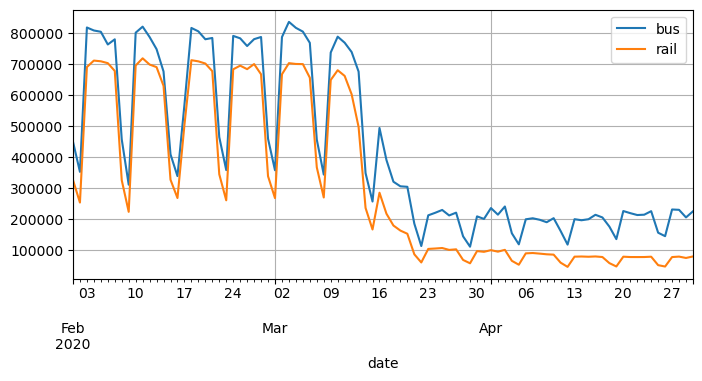

<Axes: xlabel='date'>

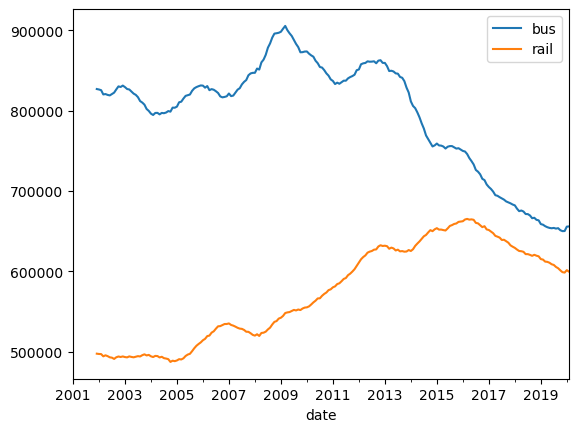

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

fp = "./datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv"
df = pd.read_csv(fp, parse_dates=["service_date"])

df = df.rename(
    columns={"service_date": "date", "rail_boardings": "rail", "total_rides": "total"}
)
df = df.set_index("date").sort_index()
df = df.drop("total", axis=1)  # total = bus + rail

df_monthly = df[:"2020-02"].resample("ME").mean(numeric_only=True)
rolling_12_month = df_monthly.rolling(12).mean()

df["2020-02":"2020-04"].plot(grid=True, figsize=(8, 3.5))


plt.show()

rolling_12_month.plot()

<Axes: xlabel='date'>

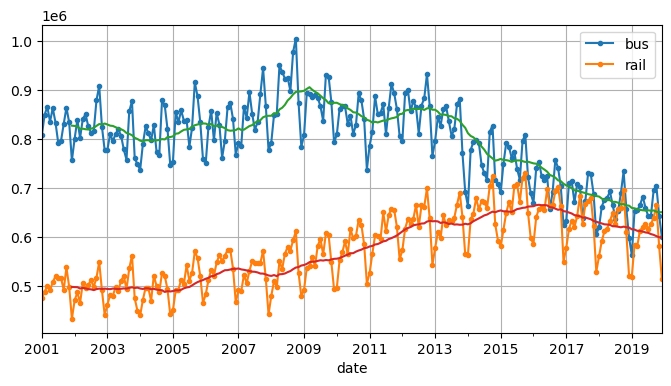

In [61]:
period = slice("2001", "2019")
df_monthly = df.resample('ME').mean(numeric_only=True)  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean(numeric_only=True)

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)

In [62]:
import tensorflow as tf

def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)


In [63]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


/opt/anaconda3/envs/deep-learning-intro-course/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4346 - mae: 0.8137 - val_loss: 0.0151 - val_mae: 0.1430
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173 - mae: 0.1467 - val_loss: 0.0070 - val_mae: 0.0881
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 - mae: 0.1012 - val_loss: 0.0057 - val_mae: 0.0787
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mae: 0.0869 - val_loss: 0.0050 - val_mae: 0.0742
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - mae: 0.0867 - val_loss: 0.0045 - val_mae: 0.0693
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0060 - mae: 0.0781 - val_loss: 0.0043 - val_mae: 0.0659
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - mae: 0.0765 - val_loss: 0.0041 - val_mae: 0.0630
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 - mae: 0.0758 - val_loss: 0.0037 - val_mae: 0.0613
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - mae: 0.0

In [64]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)

tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)


Epoch 1/500


/opt/anaconda3/envs/deep-learning-intro-course/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4465 - mae: 0.8456 - val_loss: 0.0193 - val_mae: 0.1290
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0408 - mae: 0.2222 - val_loss: 0.0631 - val_mae: 0.3086
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0500 - mae: 0.2586 - val_loss: 0.0290 - val_mae: 0.1616
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 - mae: 0.1579 - val_loss: 0.0173 - val_mae: 0.1448
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mae: 0.1666 - val_loss: 0.0170 - val_mae: 0.1405
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - mae: 0.1617 - val_loss: 0.0166 - val_mae: 0.1392
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mae: 0.1611 - val_loss: 0.0162 - val_mae: 0.1384
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - mae: 0.1607 - val_loss: 0.0158 - val_mae: 0.1369
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - mae: 0.1

In [65]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1448 - mae: 0.4351 - val_loss: 0.0125 - val_mae: 0.1437
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - mae: 0.1453 - val_loss: 0.0109 - val_mae: 0.1287
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - mae: 0.1282 - val_loss: 0.0053 - val_mae: 0.0824
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - mae: 0.0852 - val_loss: 0.0049 - val_mae: 0.0783
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mae: 0.0696 - val_loss: 0.0042 - val_mae: 0.0664
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0654 - val_loss: 0.0023 - val_mae: 0.0378
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mae: 0.0602 - val_loss: 0.0027 - val_mae: 0.0485
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - mae: 0.0557 - val_loss: 0.0036 - val_mae: 0.0599
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.004

In [66]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1145 - mae: 0.3974 - val_loss: 0.0182 - val_mae: 0.1259
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - mae: 0.1528 - val_loss: 0.0130 - val_mae: 0.1387
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0137 - mae: 0.1462 - val_loss: 0.0127 - val_mae: 0.1131
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123 - mae: 0.1364 - val_loss: 0.0086 - val_mae: 0.1090
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - mae: 0.1132 - val_loss: 0.0053 - val_mae: 0.0824
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mae: 0.0809 - val_loss: 0.0036 - val_mae: 0.0638
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0696 - val_loss: 0.0026 - val_mae: 0.0502
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0594 - val_loss: 0.0026 - val_mae: 0.0479
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.00